In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import torch

In [3]:
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "../.."))

## Start: Importing local packages. As I don't know how to run it as module
## with torchrun  (e.g., python -m trainer.Coronary_ddp_trainer)

if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.utils.logger import Logging

# Equation parameters
from src.data.helmholtz_dataset import generate_training_dataset
from src.nn.bspline import PINNKAN
from src.nn.pde import helmholtz_operator
from src.utils.plot_prediction import plt_prediction
from src.data.helmholtz_dataset import u, f


DEVICE = "cuda:0"  # torch.device("cuda" if torch.cuda.is_available() else "cpu")
# TEST_DATA_PKL = "/home/afrah/datasets/cavity/cavity.mat"
# TEST_DATA_PKL = "/home/afrah/datasets/cavity/cavity.mat"
# TEST_DATA_PKL = "/home/afrah/datasets/cavity/cavity.mat"

TEST_CHECKPOINT_PATH = os.path.join(PROJECT_ROOT, "testing_checkpoints/Helmholtz")


logger = Logging(TEST_CHECKPOINT_PATH)
model_dirname = logger.get_output_dir()

logger.print(f"Device used {DEVICE}")
logger.print(f"Result directory {model_dirname}")
# logger.print(f"MODEL_PATH {MODEL_PATH}")

INFO:src.utils.logger:Device used cuda:0
INFO:src.utils.logger:Result directory /home/ubuntu/afrah/code/pinn_learnable_activation/testing_checkpoints/Helmholtz/2024-10-11_09-15-18-128151


In [4]:
import torch


def flatten(gradients):
    """
    Flatten the gradients or list of tensors into a single 1D tensor.
    """
    return torch.cat([g.view(-1) for g in gradients])


def get_Hv(loss, weights, v):
    """
    Computes the Hessian-vector product for a given loss and vector v.
    """
    # Compute the gradient of the loss with respect to the model parameters
    loss_gradients = flatten(torch.autograd.grad(loss, weights, create_graph=True))
    # Compute the Hessian-vector product by taking the second-order gradient
    vprod = torch.dot(loss_gradients, v.detach())
    Hv_op = flatten(torch.autograd.grad(vprod, weights, retain_graph=True))
    return Hv_op


def power_iteration(model, loss, num_iters=50, tol=1e-5):
    """
    Estimates the maximum eigenvalue of the Hessian using the power iteration method.

    Args:
    - loss: The loss function (scalar) from which to compute the Hessian.
    - model: The neural network model (torch.nn.Module).
    - num_iters: Maximum number of power iterations (default is 100).
    - tol: Tolerance to stop if convergence is reached.

    Returns:
    - max_eigenvalue: The largest estimated eigenvalue of the Hessian.
    """
    loss.backward(retain_graph=True)

    # Get the model parameters (weights)
    weights = list(model.parameters())

    # Initialize a random vector for the power iteration
    v = torch.randn(flatten(weights).numel(), device=weights[0].device)
    v = v / torch.norm(v)  # Normalize the vector

    max_eigenvalue = None  # Store the maximum eigenvalue

    # Power iteration loop
    for _ in range(num_iters):
        # Compute the Hessian-vector product
        Hv = get_Hv(loss, weights, v)

        # Compute the Rayleigh quotient (an estimate for the eigenvalue)
        lambda_approx = torch.dot(v, Hv)

        # Normalize the Hessian-vector product
        v_new = Hv / torch.norm(Hv)

        # Check for convergence
        if (
            max_eigenvalue is not None
            and torch.abs(lambda_approx - max_eigenvalue) < tol
        ):
            break

        # Update the eigenvalue estimate and the vector for the next iteration
        max_eigenvalue = lambda_approx
        v = v_new

    return max_eigenvalue.item()  # Return as a scalar

In [5]:
# Set device

batch_size = 128
layers = [2, 50, 50, 50, 1]

In [6]:
def fetch_minibatch(sampler, N):
    X, Y = sampler.sample(N)
    return X, Y

In [7]:
A1 = 1
A2 = 4
LAMBDA = 1.0

# Domain boundaries

# Initialize the model, loss function, and optimizer
pinn_model = PINNKAN(layers, activation="KAN_BSpline").to(DEVICE)
optimizer = torch.optim.Adam(pinn_model.parameters(), lr=0.0005)


# Loss function
def loss_fn(r_pred, r_true):
    return torch.mean((r_pred - r_true) ** 2)


# Training loop
[bcs_sampler, res_sampler] = generate_training_dataset(DEVICE)

In [8]:
for it in range(60000):
    # Fetch boundary mini-batches
    X_bc1_batch, u_bc1_batch = fetch_minibatch(bcs_sampler[0], batch_size)
    X_bc2_batch, u_bc2_batch = fetch_minibatch(bcs_sampler[1], batch_size)
    X_bc3_batch, u_bc3_batch = fetch_minibatch(bcs_sampler[2], batch_size)
    X_bc4_batch, u_bc4_batch = fetch_minibatch(bcs_sampler[3], batch_size)

    # Fetch residual mini-batch
    X_res_batch, f_res_batch = fetch_minibatch(res_sampler, batch_size)

    u_bc1_pred = pinn_model(X_bc1_batch)

    u_bc2_pred = pinn_model(X_bc2_batch)

    u_bc3_pred = pinn_model(X_bc3_batch)

    u_bc4_pred = pinn_model(X_bc4_batch)

    x1_r, x2_r = X_res_batch[:, 0:1], X_res_batch[:, 1:2]
    [_, r_pred] = helmholtz_operator(pinn_model, x1_r, x2_r)

    optimizer.zero_grad()

    loss_r = loss_fn(r_pred, f_res_batch)
    loss_bc1 = loss_fn(u_bc1_pred, u_bc1_batch)
    loss_bc2 = loss_fn(u_bc2_pred, u_bc2_batch)
    loss_bc3 = loss_fn(u_bc3_pred, u_bc3_batch)
    loss_bc4 = loss_fn(u_bc4_pred, u_bc4_batch)

    loss_bc = loss_bc1 + loss_bc2 + loss_bc3 + loss_bc4
    loss = loss_r + 10.0 * (loss_bc)

    # if it % 100 == 0:
    #     scheduler.step()

    if it % 10000 == 0:
        # Example usage:
        # Assuming you have `model`, `loss_fn`, `input_data`, and `target` defined
        max_eigenvalue = power_iteration(pinn_model, loss_bc)
        print(
            f"Maximum eigenvalue of the Hessian of the total loss with respect to nn parameters: {max_eigenvalue:2.2e}"
        )

        logger.print(
            "Iteration: %d, loss_r = %.1e ,  loss_bc = %.1e,  lr = %0.1e"
            % (
                it,
                loss_r.item(),
                loss_bc.item(),
                optimizer.param_groups[0]["lr"],
            )
        )
    loss.backward(retain_graph=True)
    optimizer.step()

/home/ubuntu/miniconda3/envs/pytorch-2.3.1-corona-pinn/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /opt/conda/conda-bld/pytorch_1716905969824/work/aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
INFO:src.utils.logger:Iteration: 0, loss_r = 7.2e+03 ,  loss_bc = 2.7e-04,  lr = 5.0e-04


Maximum eigenvalue of the Hessian of the total loss with respect to nn parameters: 1.12e+00


INFO:src.utils.logger:Iteration: 10000, loss_r = 1.7e+00 ,  loss_bc = 6.2e-03,  lr = 5.0e-04


Maximum eigenvalue of the Hessian of the total loss with respect to nn parameters: 7.68e+02


INFO:src.utils.logger:Iteration: 20000, loss_r = 1.5e+00 ,  loss_bc = 1.0e-02,  lr = 5.0e-04


Maximum eigenvalue of the Hessian of the total loss with respect to nn parameters: 5.65e+02


INFO:src.utils.logger:Iteration: 30000, loss_r = 5.1e-01 ,  loss_bc = 2.5e-03,  lr = 5.0e-04


Maximum eigenvalue of the Hessian of the total loss with respect to nn parameters: 4.80e+02


INFO:src.utils.logger:Iteration: 40000, loss_r = 3.9e-01 ,  loss_bc = 1.2e-03,  lr = 5.0e-04


Maximum eigenvalue of the Hessian of the total loss with respect to nn parameters: 4.12e+02


INFO:src.utils.logger:Iteration: 50000, loss_r = 3.2e-01 ,  loss_bc = 9.9e-04,  lr = 5.0e-04


Maximum eigenvalue of the Hessian of the total loss with respect to nn parameters: 3.51e+02


/home/ubuntu/miniconda3/envs/pytorch-2.3.1-corona-pinn/lib/python3.9/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1716905969824/work/aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
INFO:src.utils.logger:Relative L2 error_u: 2.81e+00
INFO:src.utils.logger:Relative L2 error_f: 6.43e-01


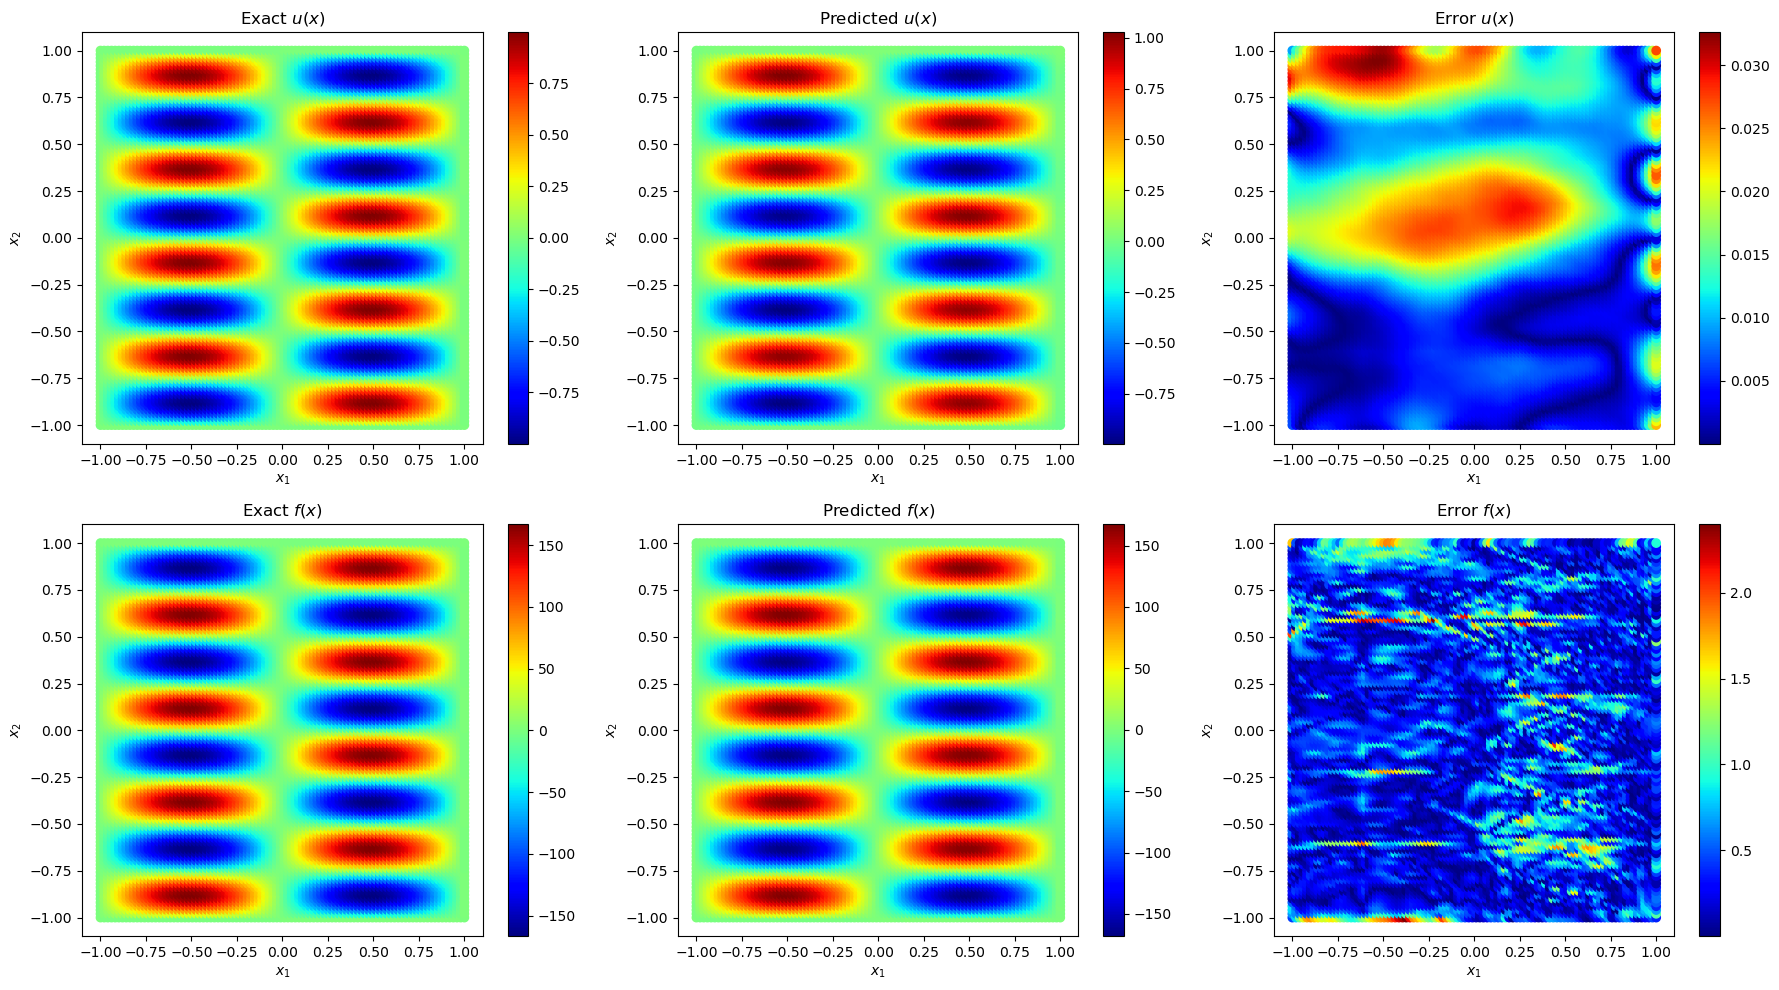

In [9]:
# Test data
num_points = 100

dom_coords = torch.tensor([[-1.0, -1.0], [1.0, 1.0]], dtype=torch.float32).to(DEVICE)

t = (
    torch.linspace(dom_coords[0, 0], dom_coords[1, 0], num_points)
    .to(DEVICE)
    .unsqueeze(1)
)
x = (
    torch.linspace(dom_coords[0, 1], dom_coords[1, 1], num_points)
    .to(DEVICE)
    .unsqueeze(1)
)
t, x = torch.meshgrid(t.squeeze(), x.squeeze())
X_star = torch.hstack((t.flatten().unsqueeze(1), x.flatten().unsqueeze(1))).to(DEVICE)

# Predictions
u_pred_star, f_pred_star = helmholtz_operator(
    pinn_model, X_star[:, 0:1], X_star[:, 1:2]
)

# Exact solution
u_star = u(X_star, A1, A2)
f_star = f(X_star, A1, A2, LAMBDA)

# Relative L2 error
error_u = torch.norm(u_pred_star - u_star, 2) / torch.norm(u_star, 2) * 100
error_f = torch.norm(f_pred_star - f_star, 2) / torch.norm(f_star, 2) * 100
logger.print("Relative L2 error_u: {:.2e}".format(error_u.item()))
logger.print("Relative L2 error_f: {:.2e}".format(error_f.item()))


# Plot predictions
plt_prediction(
    logger,
    X_star.cpu().detach().numpy(),
    u_star.cpu().detach().numpy(),
    u_pred_star.cpu().detach().numpy(),
    f_star.cpu().detach().numpy(),
    f_pred_star.cpu().detach().numpy(),
)

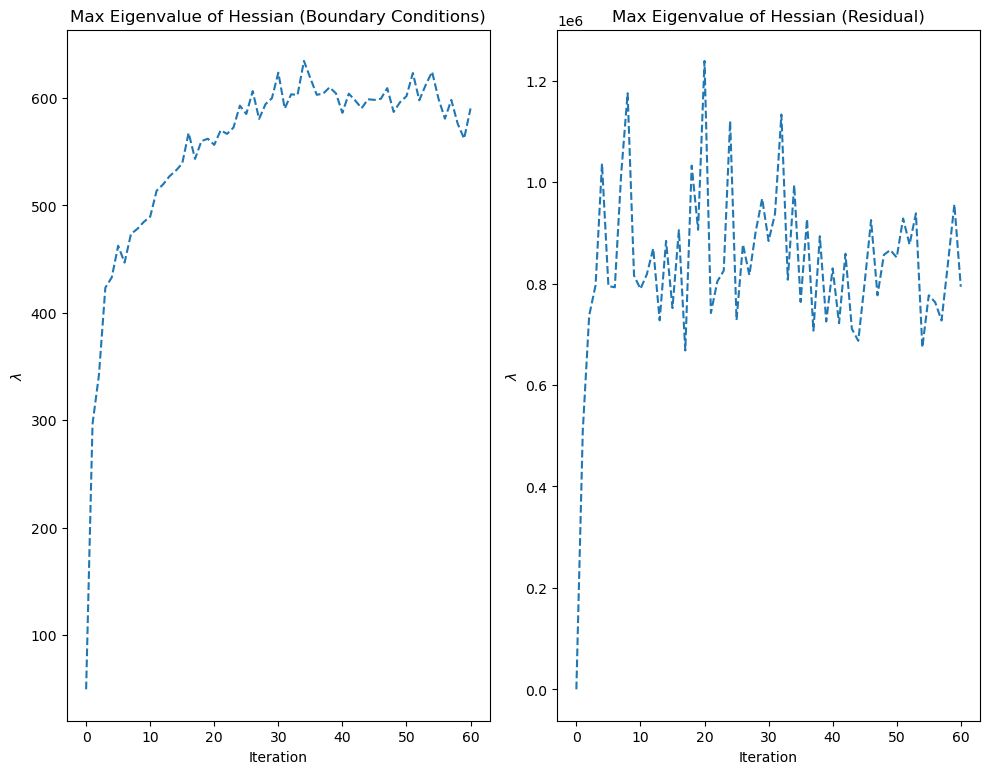

In [21]:
from matplotlib import pyplot as plt


model_path = "/home/ubuntu/afrah/code/pinn_learnable_activation/checkpoints/helmhlotz/2024-10-11_12-23-45-689324/model.pth"

state = torch.load(
    model_path,
)

max_eig_hessian_bc_log = state.get("max_eig_hessian_bc_log")
max_eig_hessian_res_log = state.get("max_eig_hessian_res_log")
fig, axs = plt.subplots(1, 2, figsize=(10, 8))

axs[0].plot(max_eig_hessian_bc_log, "--")
axs[0].set_title("Max Eigenvalue of Hessian (Boundary Conditions)")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel(r"$\lambda$")

axs[1].plot(max_eig_hessian_res_log, "--")
axs[1].set_title("Max Eigenvalue of Hessian (Residual)")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel(r"$\lambda$")

plt.tight_layout()
plt.show()

In [ ]:
max_eig_hessian_bc_log